## Loading the dataset

In [1]:
import pandas as pd
df = pd.read_csv("./mouth_year.csv")
df.head()

,production,p_per_m2,p_max,panel_area,facade_area,total_panel_area,exploitation_ratio,air_temp_mean,air_temp_max,clearsky_ghi_mean,...,relative_humidity_max,surface_pressure_mean,surface_pressure_min,surface_pressure_max,wind_direction_100m_mean,wind_direction_100m_min,wind_direction_100m_max,wind_speed_100m_mean,wind_speed_100m_min,wind_speed_100m_max
0,7.461290,143.0,210.0,1.72,218.0,94.6,0.434,1.885252,3.612903,72.773750,...,90.400000,1017.477354,1013.751613,1021.354839,213.224691,148.193548,273.870968,5.215817,3.112903,7.035484
1,3.100000,143.0,210.0,1.72,218.0,94.6,0.434,2.395833,4.000000,72.791667,...,90.600000,1017.168750,1015.500000,1021.000000,227.041667,192.000000,283.000000,4.781250,2.600000,7.400000
2,30.171429,143.0,210.0,1.72,218.0,94.6,0.434,5.704613,11.500000,120.002232,...,87.157143,1024.363914,1021.210714,1027.460714,179.183036,127.214286,233.535714,4.203720,2.382143,6.142857
3,39.050000,143.0,210.0,1.72,218.0,94.6,0.434,6.229167,12.000000,117.760417,...,90.050000,1026.685417,1023.400000,1030.000000,191.343750,154.000000,217.000000,3.611458,1.450000,5.500000
4,26.516129,143.0,210.0,1.72,218.0,94.6,0.434,8.653686,12.870968,189.389254,...,85.245161,1020.149565,1016.722581,1023.654839,180.347464,125.225806,232.806452,6.274361,3.974194,8.567742


## Preoaring the (x,y) pairs

### Scaling the data

In [2]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df.values)

### Creating windows

In [3]:
production_column = 'production'

def get_target_column_index(df, target_column):
    for i, column in enumerate(df.columns):
        if column == target_column:
            return i

    return -1

In [4]:
import numpy as np

def get_windows(data, window_size=10):
    x = []
    y = []

    for i in range(window_size, len(data)):
        x.append(data[i-window_size:i])
        y.append(data[i][get_target_column_index(df, production_column)])

    return np.array(x), np.array(y)

In [5]:
window_size = 2*12  # 2*1h window
x, y = get_windows(data_scaled, window_size=window_size)

x.shape, y.shape

((702, 24, 34), (702,))

### Splitting the data

In [6]:
train_split_index = int(0.8 * len(df))
test_split_index = int(0.9 * len(df))

x_train, y_train = x[:train_split_index], y[:train_split_index]
x_test, y_test = x[train_split_index:test_split_index], y[train_split_index:test_split_index]
x_val, y_val = x[test_split_index:], y[test_split_index:]

x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((580, 24, 34), (580,), (73, 24, 34), (73,), (49, 24, 34), (49,))

### Plotting the splits

In [7]:
import matplotlib.pyplot as plt


def plot_time_series(timesteps, values, label, format='-^', start=0, end=None):
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("date")
    plt.ylabel("production")

    plt.legend(fontsize=14)
    plt.grid(True)

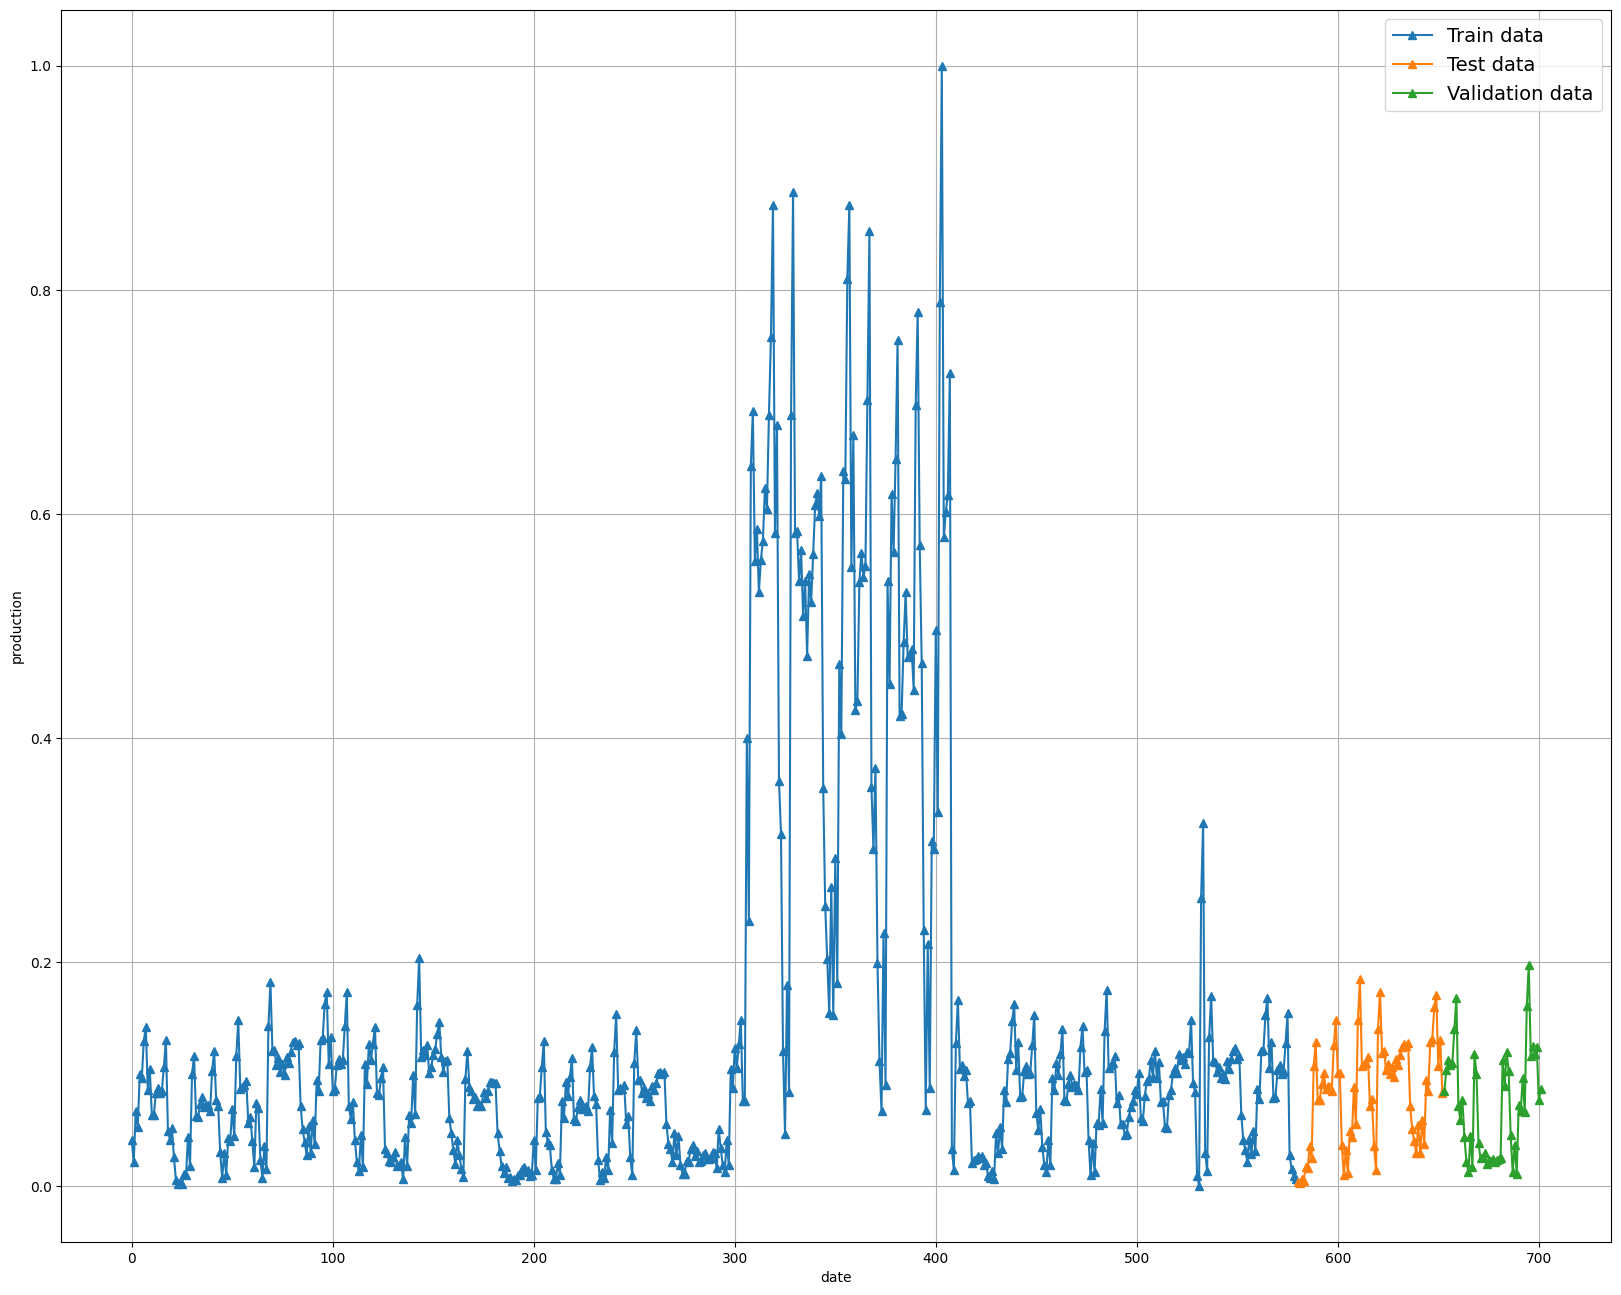

In [8]:
plt.figure(figsize=(20, 16))

timesteps = range(len(x_train))
plot_time_series(timesteps=timesteps, values=y_train, label="Train data")

timesteps = range(len(x_train), len(x_train) + len(x_test))
plot_time_series(timesteps=timesteps, values=y_test, label="Test data")

timesteps = range(len(x_train) + len(x_test),
                  len(x_train) + len(x_test) + len(x_val))
plot_time_series(timesteps=timesteps, values=y_val, label="Validation data")

### Preparing the performances metrics

In [9]:
import tensorflow as tf
from sklearn.metrics import r2_score

In [10]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return {
        'mse': mse,
        'r2': r2,
        'mae': mae,
        'mape': mape,
    }

In [11]:
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae_metric = tf.keras.metrics.MeanAbsoluteError()
    mse_metric = tf.keras.metrics.MeanSquaredError()

    mae_metric.update_state(y_true, y_pred)
    mse_metric.update_state(y_true, y_pred)

    mae = mae_metric.result().numpy()
    mse = mse_metric.result().numpy()
    r2 = r2_score(y_true.numpy(), y_pred.numpy())  # Assure-toi que y_true et y_pred sont des numpy arrays

    return {
        "mae": mae,
        "mse": mse,
        "r2": r2
    }

## Modeling

In [12]:
import os
import tensorflow as tf

from keras.layers import Dense, Dropout, LSTM, Flatten, ConvLSTM1D, MaxPool1D, GlobalMaxPool1D, Conv1D, Conv2D
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

### Plotting the loss

In [13]:
def plot_loss(history):
    plt.figure(figsize=(20, 8))

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

### Creating callbacks

In [14]:
stop_early = EarlyStopping(monitor='val_loss', patience=5)


def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                              verbose=0,
                                              save_best_only=True)

### Utils function

In [15]:
def make_preds(model, input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

## ConvLSTM

#### Preparing the model

In [16]:
x_train_conv_lstm = np.expand_dims(x_train, axis=2)
x_val_conv_lstm = np.expand_dims(x_val, axis=2)
x_test_conv_lstm = np.expand_dims(x_test, axis=2)

print(f"{x_train.shape} -> {x_train_conv_lstm.shape}")

(580, 24, 34) -> (580, 24, 1, 34)


In [17]:
from tensorflow.keras.layers import ConvLSTM1D, Flatten, Dense

# Hyperparamètres optimisés
filters = 32
kernel_size = 1
activation = 'relu'
dense_units = 32
learning_rate = 0.0025360526576190816

tf.random.set_seed(42)

input_shape = (x_train_conv_lstm.shape[1:])
conv_lstm_model = tf.keras.Sequential([
    ConvLSTM1D(filters=filters, kernel_size=(kernel_size,), activation=activation,
               return_sequences=True, input_shape=input_shape),
    ConvLSTM1D(filters=filters, kernel_size=(kernel_size,), activation=activation,
               return_sequences=False),
    Flatten(),
    Dense(units=dense_units, activation='relu'),
    Dense(1, activation="linear")
], name="model_conv_lstm.keras")

conv_lstm_model.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
)

conv_lstm_model.summary()


Model: "model_conv_lstm.keras"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm1d (ConvLSTM1D)    (None, 24, 1, 32)         8576      
                                                                 
 conv_lstm1d_1 (ConvLSTM1D)  (None, 1, 32)             8320      
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 17985 (70.25 KB)
Trainable params: 17985 (70.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Training the model convlstm

In [18]:
import os
import time
import logging
from codecarbon import EmissionsTracker


os.makedirs('emissions', exist_ok=True)

tracker_conv_lstm = EmissionsTracker(
    project_name="PEWH",
    co2_signal_api_token="9RkoBO6iipmoq",
    log_level=logging.INFO,
    output_file="emissions_conv_lstm.csv",
    output_dir='./emissions/',
    save_to_file=True,
    measure_power_secs=10
)

[codecarbon INFO @ 03:43:42] [setup] RAM Tracking...
[codecarbon INFO @ 03:43:42] [setup] CPU Tracking...
[codecarbon WARNING @ 03:43:42] No CPU tracking mode found. Falling back on CPU constant mode. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon WARNING @ 03:43:43] We saw that you have a 12th Gen Intel(R) Core(TM) i7-12700H but we don't know it. Please contact us.
[codecarbon INFO @ 03:43:43] CPU Model on constant consumption mode: 12th Gen Intel(R) Core(TM) i7-12700H
[codecarbon INFO @ 03:43:43] [setup] GPU Tracking...
[codecarbon INFO @ 03:43:45] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 03:43:45] >>> Tracker's metadata:
[codecarbon INFO @ 03:43:45]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 03:43:45]   Python version: 3.11.3
[codecarbon INFO @ 03:43:45]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 03:43:45]   Available RAM : 31.711 GB
[codecarbon INFO @ 03:43:45]   CPU count: 20
[codecarbon INFO @ 03:43:45]   CPU

In [19]:
def start_training_conv_lstm():
    start_time = time.time()
    conv_lstm_history = conv_lstm_model.fit(x=x_train_conv_lstm,
                                            y=y_train,
                                            epochs=300,
                                            verbose=1,
                                            batch_size=512,
                                            validation_data=(
                                                x_val_conv_lstm, y_val),
                                            callbacks=[create_model_checkpoint(model_name=conv_lstm_model.name)])
    training_duration = time.time() - start_time

    return conv_lstm_history, training_duration

In [20]:
tracker_conv_lstm.start()
try:
    history_conv_lstm, training_duration_conv_lstm = start_training_conv_lstm()
finally:
    tracker_conv_lstm.stop()

Epoch 1/300



[codecarbon INFO @ 03:43:56] Energy consumed for RAM : 0.000036 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 03:43:56] Energy consumed for all CPUs : 0.000129 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:43:57] Energy consumed for all GPUs : 0.000004 kWh. Total GPU Power : 1.3764522441938758 W
[codecarbon INFO @ 03:43:57] 0.000169 kWh of electricity used since the beginning.


2/2 [==============================] - 13s 2s/step - loss: 0.1644 - val_loss: 0.0418
Epoch 2/300
2/2 [==============================] - 0s 162ms/step - loss: 0.1022 - val_loss: 0.0582
Epoch 3/300
2/2 [==============================] - 0s 237ms/step - loss: 0.0963 - val_loss: 0.0391
Epoch 4/300
2/2 [==============================] - 0s 239ms/step - loss: 0.0846 - val_loss: 0.0380
Epoch 5/300
2/2 [==============================] - 0s 158ms/step - loss: 0.0754 - val_loss: 0.0424
Epoch 6/300
2/2 [==============================] - 0s 164ms/step - loss: 0.0888 - val_loss: 0.0444
Epoch 7/300
2/2 [==============================] - 0s 153ms/step - loss: 0.0835 - val_loss: 0.0437
Epoch 8/300
2/2 [==============================] - 0s 148ms/step - loss: 0.0855 - val_loss: 0.0431
Epoch 9/300
2/2 [==============================] - 0s 146ms/step - loss: 0.0722 - val_loss: 0.0419
Epoch 10/300
2/2 [==============================] - 0s 154ms/step - loss: 0.0746 - val_loss: 0.0435
Epoch 11/300
2/2 [=====

[codecarbon INFO @ 03:44:06] Energy consumed for RAM : 0.000064 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 03:44:06] Energy consumed for all CPUs : 0.000231 kWh. Total CPU Power : 42.5 W


2/2 [==============================] - 0s 146ms/step - loss: 0.0627 - val_loss: 0.0413
Epoch 25/300
2/2 [==============================] - 0s 142ms/step - loss: 0.0603 - val_loss: 0.0382
Epoch 26/300
2/2 [==============================] - 0s 205ms/step - loss: 0.0568 - val_loss: 0.0377
Epoch 27/300
2/2 [==============================] - 0s 146ms/step - loss: 0.0567 - val_loss: 0.0407
Epoch 28/300
2/2 [==============================] - 0s 141ms/step - loss: 0.0604 - val_loss: 0.0402
Epoch 29/300


[codecarbon INFO @ 03:44:07] Energy consumed for all GPUs : 0.000014 kWh. Total GPU Power : 3.960198399732084 W
[codecarbon INFO @ 03:44:07] 0.000309 kWh of electricity used since the beginning.


2/2 [==============================] - 0s 135ms/step - loss: 0.0615 - val_loss: 0.0402
Epoch 30/300
2/2 [==============================] - 0s 155ms/step - loss: 0.0574 - val_loss: 0.0401
Epoch 31/300
2/2 [==============================] - 0s 162ms/step - loss: 0.0554 - val_loss: 0.0428
Epoch 32/300
2/2 [==============================] - 0s 233ms/step - loss: 0.0607 - val_loss: 0.0357
Epoch 33/300
2/2 [==============================] - 0s 226ms/step - loss: 0.0532 - val_loss: 0.0350
Epoch 34/300
2/2 [==============================] - 0s 161ms/step - loss: 0.0529 - val_loss: 0.0366
Epoch 35/300
2/2 [==============================] - 0s 159ms/step - loss: 0.0530 - val_loss: 0.0368
Epoch 36/300
2/2 [==============================] - 0s 154ms/step - loss: 0.0505 - val_loss: 0.0365
Epoch 37/300
2/2 [==============================] - 0s 150ms/step - loss: 0.0500 - val_loss: 0.0367
Epoch 38/300
2/2 [==============================] - 0s 152ms/step - loss: 0.0492 - val_loss: 0.0405
Epoch 39/300


[codecarbon INFO @ 03:44:16] Energy consumed for RAM : 0.000093 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 03:44:16] Energy consumed for all CPUs : 0.000333 kWh. Total CPU Power : 42.5 W


2/2 [==============================] - 0s 156ms/step - loss: 0.0443 - val_loss: 0.0365
Epoch 60/300
2/2 [==============================] - 0s 136ms/step - loss: 0.0493 - val_loss: 0.0385
Epoch 61/300
2/2 [==============================] - 0s 142ms/step - loss: 0.0451 - val_loss: 0.0394
Epoch 62/300
2/2 [==============================] - 0s 208ms/step - loss: 0.0461 - val_loss: 0.0337
Epoch 63/300
2/2 [==============================] - 0s 152ms/step - loss: 0.0428 - val_loss: 0.0350
Epoch 64/300


[codecarbon INFO @ 03:44:17] Energy consumed for all GPUs : 0.000023 kWh. Total GPU Power : 3.986774472226836 W
[codecarbon INFO @ 03:44:17] 0.000449 kWh of electricity used since the beginning.


2/2 [==============================] - 0s 119ms/step - loss: 0.0438 - val_loss: 0.0364
Epoch 65/300
2/2 [==============================] - 0s 133ms/step - loss: 0.0457 - val_loss: 0.0347
Epoch 66/300
2/2 [==============================] - 0s 155ms/step - loss: 0.0423 - val_loss: 0.0356
Epoch 67/300
2/2 [==============================] - 0s 147ms/step - loss: 0.0436 - val_loss: 0.0354
Epoch 68/300
2/2 [==============================] - 0s 153ms/step - loss: 0.0422 - val_loss: 0.0371
Epoch 69/300
2/2 [==============================] - 0s 142ms/step - loss: 0.0426 - val_loss: 0.0354
Epoch 70/300
2/2 [==============================] - 0s 159ms/step - loss: 0.0416 - val_loss: 0.0344
Epoch 71/300
2/2 [==============================] - 0s 159ms/step - loss: 0.0399 - val_loss: 0.0346
Epoch 72/300
2/2 [==============================] - 0s 151ms/step - loss: 0.0419 - val_loss: 0.0350
Epoch 73/300
2/2 [==============================] - 0s 155ms/step - loss: 0.0414 - val_loss: 0.0352
Epoch 74/300


[codecarbon INFO @ 03:44:26] Energy consumed for RAM : 0.000121 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 03:44:26] Energy consumed for all CPUs : 0.000434 kWh. Total CPU Power : 42.5 W


2/2 [==============================] - 0s 160ms/step - loss: 0.0393 - val_loss: 0.0346
Epoch 96/300
2/2 [==============================] - 0s 140ms/step - loss: 0.0394 - val_loss: 0.0348
Epoch 97/300
2/2 [==============================] - 0s 222ms/step - loss: 0.0405 - val_loss: 0.0329
Epoch 98/300
2/2 [==============================] - 0s 168ms/step - loss: 0.0400 - val_loss: 0.0327
Epoch 99/300
2/2 [==============================] - 0s 158ms/step - loss: 0.0400 - val_loss: 0.0335
Epoch 100/300
1/2 [==============>...............] - ETA: 0s - loss: 0.0417

[codecarbon INFO @ 03:44:27] Energy consumed for all GPUs : 0.000033 kWh. Total GPU Power : 4.013127865685191 W
[codecarbon INFO @ 03:44:27] 0.000588 kWh of electricity used since the beginning.


2/2 [==============================] - 0s 127ms/step - loss: 0.0400 - val_loss: 0.0328
Epoch 101/300
2/2 [==============================] - 0s 136ms/step - loss: 0.0382 - val_loss: 0.0328
Epoch 102/300
2/2 [==============================] - 0s 208ms/step - loss: 0.0389 - val_loss: 0.0327
Epoch 103/300
2/2 [==============================] - 0s 141ms/step - loss: 0.0385 - val_loss: 0.0336
Epoch 104/300
2/2 [==============================] - 0s 145ms/step - loss: 0.0383 - val_loss: 0.0342
Epoch 105/300
2/2 [==============================] - 0s 139ms/step - loss: 0.0412 - val_loss: 0.0374
Epoch 106/300
2/2 [==============================] - 0s 151ms/step - loss: 0.0409 - val_loss: 0.0356
Epoch 107/300
2/2 [==============================] - 0s 144ms/step - loss: 0.0391 - val_loss: 0.0339
Epoch 108/300
2/2 [==============================] - 0s 145ms/step - loss: 0.0392 - val_loss: 0.0348
Epoch 109/300
2/2 [==============================] - 0s 164ms/step - loss: 0.0388 - val_loss: 0.0339
Epoc

[codecarbon INFO @ 03:44:36] Energy consumed for RAM : 0.000150 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 03:44:36] Energy consumed for all CPUs : 0.000536 kWh. Total CPU Power : 42.5 W


2/2 [==============================] - 0s 162ms/step - loss: 0.0425 - val_loss: 0.0339
Epoch 132/300
2/2 [==============================] - 0s 148ms/step - loss: 0.0379 - val_loss: 0.0325
Epoch 133/300
2/2 [==============================] - 0s 213ms/step - loss: 0.0378 - val_loss: 0.0318
Epoch 134/300
2/2 [==============================] - 0s 147ms/step - loss: 0.0383 - val_loss: 0.0324
Epoch 135/300
2/2 [==============================] - 0s 150ms/step - loss: 0.0378 - val_loss: 0.0326
Epoch 136/300


[codecarbon INFO @ 03:44:37] Energy consumed for all GPUs : 0.000042 kWh. Total GPU Power : 4.018427474920406 W
[codecarbon INFO @ 03:44:37] 0.000728 kWh of electricity used since the beginning.


2/2 [==============================] - 0s 146ms/step - loss: 0.0369 - val_loss: 0.0334
Epoch 137/300
2/2 [==============================] - 0s 134ms/step - loss: 0.0373 - val_loss: 0.0363
Epoch 138/300
2/2 [==============================] - 0s 158ms/step - loss: 0.0385 - val_loss: 0.0340
Epoch 139/300
2/2 [==============================] - 0s 153ms/step - loss: 0.0380 - val_loss: 0.0332
Epoch 140/300
2/2 [==============================] - 0s 148ms/step - loss: 0.0370 - val_loss: 0.0329
Epoch 141/300
2/2 [==============================] - 0s 154ms/step - loss: 0.0375 - val_loss: 0.0318
Epoch 142/300
2/2 [==============================] - 0s 148ms/step - loss: 0.0367 - val_loss: 0.0329
Epoch 143/300
2/2 [==============================] - 0s 152ms/step - loss: 0.0367 - val_loss: 0.0332
Epoch 144/300
2/2 [==============================] - 0s 146ms/step - loss: 0.0385 - val_loss: 0.0335
Epoch 145/300
2/2 [==============================] - 0s 165ms/step - loss: 0.0373 - val_loss: 0.0342
Epoc

[codecarbon INFO @ 03:44:46] Energy consumed for RAM : 0.000178 kWh. RAM Power : 11.891499996185303 W


2/2 [==============================] - 0s 172ms/step - loss: 0.0356 - val_loss: 0.0330
Epoch 166/300


[codecarbon INFO @ 03:44:46] Energy consumed for all CPUs : 0.000638 kWh. Total CPU Power : 42.5 W


2/2 [==============================] - 0s 151ms/step - loss: 0.0359 - val_loss: 0.0318
Epoch 167/300
2/2 [==============================] - 0s 144ms/step - loss: 0.0344 - val_loss: 0.0311
Epoch 168/300
2/2 [==============================] - 0s 137ms/step - loss: 0.0346 - val_loss: 0.0315
Epoch 169/300
2/2 [==============================] - 0s 136ms/step - loss: 0.0360 - val_loss: 0.0353
Epoch 170/300
2/2 [==============================] - 0s 154ms/step - loss: 0.0390 - val_loss: 0.0330
Epoch 171/300


[codecarbon INFO @ 03:44:47] Energy consumed for all GPUs : 0.000052 kWh. Total GPU Power : 4.124091143313619 W
[codecarbon INFO @ 03:44:47] 0.000868 kWh of electricity used since the beginning.


2/2 [==============================] - 0s 123ms/step - loss: 0.0386 - val_loss: 0.0325
Epoch 172/300
2/2 [==============================] - 0s 140ms/step - loss: 0.0368 - val_loss: 0.0316
Epoch 173/300
2/2 [==============================] - 0s 145ms/step - loss: 0.0351 - val_loss: 0.0325
Epoch 174/300
2/2 [==============================] - 0s 154ms/step - loss: 0.0357 - val_loss: 0.0337
Epoch 175/300
2/2 [==============================] - 0s 164ms/step - loss: 0.0363 - val_loss: 0.0345
Epoch 176/300
2/2 [==============================] - 0s 155ms/step - loss: 0.0396 - val_loss: 0.0336
Epoch 177/300
2/2 [==============================] - 0s 146ms/step - loss: 0.0378 - val_loss: 0.0312
Epoch 178/300
2/2 [==============================] - 0s 156ms/step - loss: 0.0344 - val_loss: 0.0330
Epoch 179/300
2/2 [==============================] - 0s 150ms/step - loss: 0.0375 - val_loss: 0.0316
Epoch 180/300
2/2 [==============================] - 0s 222ms/step - loss: 0.0357 - val_loss: 0.0300
Epoc

[codecarbon INFO @ 03:44:56] Energy consumed for RAM : 0.000206 kWh. RAM Power : 11.891499996185303 W


1/2 [==============>...............] - ETA: 0s - loss: 0.0477

[codecarbon INFO @ 03:44:56] Energy consumed for all CPUs : 0.000739 kWh. Total CPU Power : 42.5 W


2/2 [==============================] - 0s 165ms/step - loss: 0.0472 - val_loss: 0.0314
Epoch 202/300
2/2 [==============================] - 0s 141ms/step - loss: 0.0365 - val_loss: 0.0371
Epoch 203/300
2/2 [==============================] - 0s 136ms/step - loss: 0.0414 - val_loss: 0.0320
Epoch 204/300
2/2 [==============================] - 0s 138ms/step - loss: 0.0382 - val_loss: 0.0324
Epoch 205/300
2/2 [==============================] - 0s 133ms/step - loss: 0.0360 - val_loss: 0.0355
Epoch 206/300
2/2 [==============================] - ETA: 0s - loss: 0.0419

[codecarbon INFO @ 03:44:57] Energy consumed for all GPUs : 0.000062 kWh. Total GPU Power : 4.052073293882762 W
[codecarbon INFO @ 03:44:57] 0.001008 kWh of electricity used since the beginning.


2/2 [==============================] - 0s 143ms/step - loss: 0.0419 - val_loss: 0.0346
Epoch 207/300
2/2 [==============================] - 0s 134ms/step - loss: 0.0403 - val_loss: 0.0302
Epoch 208/300
2/2 [==============================] - 0s 140ms/step - loss: 0.0351 - val_loss: 0.0347
Epoch 209/300
2/2 [==============================] - 0s 155ms/step - loss: 0.0389 - val_loss: 0.0332
Epoch 210/300
2/2 [==============================] - 0s 157ms/step - loss: 0.0414 - val_loss: 0.0305
Epoch 211/300
2/2 [==============================] - 0s 149ms/step - loss: 0.0369 - val_loss: 0.0345
Epoch 212/300
2/2 [==============================] - 0s 160ms/step - loss: 0.0381 - val_loss: 0.0324
Epoch 213/300
2/2 [==============================] - 0s 139ms/step - loss: 0.0373 - val_loss: 0.0301
Epoch 214/300
2/2 [==============================] - 0s 167ms/step - loss: 0.0342 - val_loss: 0.0302
Epoch 215/300
2/2 [==============================] - 0s 157ms/step - loss: 0.0348 - val_loss: 0.0330
Epoc

[codecarbon INFO @ 03:45:06] Energy consumed for RAM : 0.000235 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 03:45:06] Energy consumed for all CPUs : 0.000841 kWh. Total CPU Power : 42.5 W


2/2 [==============================] - 0s 146ms/step - loss: 0.0319 - val_loss: 0.0299
Epoch 238/300
2/2 [==============================] - 0s 142ms/step - loss: 0.0328 - val_loss: 0.0297
Epoch 239/300
2/2 [==============================] - 0s 131ms/step - loss: 0.0340 - val_loss: 0.0310
Epoch 240/300
2/2 [==============================] - 0s 130ms/step - loss: 0.0360 - val_loss: 0.0284
Epoch 241/300
2/2 [==============================] - 0s 133ms/step - loss: 0.0341 - val_loss: 0.0273
Epoch 242/300
2/2 [==============================] - 0s 139ms/step - loss: 0.0327 - val_loss: 0.0280


[codecarbon INFO @ 03:45:07] Energy consumed for all GPUs : 0.000072 kWh. Total GPU Power : 4.141163479206281 W


Epoch 243/300


[codecarbon INFO @ 03:45:07] 0.001148 kWh of electricity used since the beginning.


2/2 [==============================] - 0s 136ms/step - loss: 0.0324 - val_loss: 0.0287


[codecarbon INFO @ 03:45:08] 0.000348 g.CO2eq/s mean an estimation of 10.984237379161144 kg.CO2eq/year


Epoch 244/300
2/2 [==============================] - 0s 152ms/step - loss: 0.0324 - val_loss: 0.0279
Epoch 245/300
2/2 [==============================] - 0s 148ms/step - loss: 0.0314 - val_loss: 0.0276
Epoch 246/300
2/2 [==============================] - 0s 152ms/step - loss: 0.0314 - val_loss: 0.0273
Epoch 247/300
2/2 [==============================] - 0s 156ms/step - loss: 0.0318 - val_loss: 0.0288
Epoch 248/300
2/2 [==============================] - 0s 141ms/step - loss: 0.0321 - val_loss: 0.0297
Epoch 249/300
2/2 [==============================] - 0s 153ms/step - loss: 0.0318 - val_loss: 0.0288
Epoch 250/300
2/2 [==============================] - 0s 153ms/step - loss: 0.0328 - val_loss: 0.0284
Epoch 251/300
2/2 [==============================] - 0s 198ms/step - loss: 0.0340 - val_loss: 0.0271
Epoch 252/300
2/2 [==============================] - 0s 234ms/step - loss: 0.0345 - val_loss: 0.0261
Epoch 253/300
2/2 [==============================] - 0s 156ms/step - loss: 0.0326 - val_los

[codecarbon INFO @ 03:45:16] Energy consumed for RAM : 0.000263 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 03:45:16] Energy consumed for all CPUs : 0.000943 kWh. Total CPU Power : 42.5 W


2/2 [==============================] - 0s 155ms/step - loss: 0.0317 - val_loss: 0.0257
Epoch 274/300
2/2 [==============================] - 0s 146ms/step - loss: 0.0312 - val_loss: 0.0264
Epoch 275/300
2/2 [==============================] - 0s 131ms/step - loss: 0.0327 - val_loss: 0.0255
Epoch 276/300
2/2 [==============================] - 0s 143ms/step - loss: 0.0301 - val_loss: 0.0251
Epoch 277/300
2/2 [==============================] - 0s 142ms/step - loss: 0.0300 - val_loss: 0.0254
Epoch 278/300
2/2 [==============================] - ETA: 0s - loss: 0.0291

[codecarbon INFO @ 03:45:17] Energy consumed for all GPUs : 0.000082 kWh. Total GPU Power : 4.12337770461978 W
[codecarbon INFO @ 03:45:17] 0.001288 kWh of electricity used since the beginning.


2/2 [==============================] - 0s 136ms/step - loss: 0.0291 - val_loss: 0.0250
Epoch 279/300
2/2 [==============================] - 0s 209ms/step - loss: 0.0289 - val_loss: 0.0246
Epoch 280/300
2/2 [==============================] - 0s 138ms/step - loss: 0.0298 - val_loss: 0.0271
Epoch 281/300
2/2 [==============================] - 0s 159ms/step - loss: 0.0328 - val_loss: 0.0301
Epoch 282/300
2/2 [==============================] - 0s 151ms/step - loss: 0.0341 - val_loss: 0.0281
Epoch 283/300
2/2 [==============================] - 0s 152ms/step - loss: 0.0351 - val_loss: 0.0260
Epoch 284/300
2/2 [==============================] - 0s 153ms/step - loss: 0.0334 - val_loss: 0.0257
Epoch 285/300
2/2 [==============================] - 0s 158ms/step - loss: 0.0322 - val_loss: 0.0284
Epoch 286/300
2/2 [==============================] - 0s 165ms/step - loss: 0.0329 - val_loss: 0.0289
Epoch 287/300
2/2 [==============================] - 0s 148ms/step - loss: 0.0347 - val_loss: 0.0255
Epoc

[codecarbon INFO @ 03:45:24] Energy consumed for RAM : 0.000284 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 03:45:24] Energy consumed for all CPUs : 0.001018 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:45:25] Energy consumed for all GPUs : 0.000091 kWh. Total GPU Power : 5.423388755852448 W
[codecarbon INFO @ 03:45:25] 0.001394 kWh of electricity used since the beginning.


#### Ploting the loss

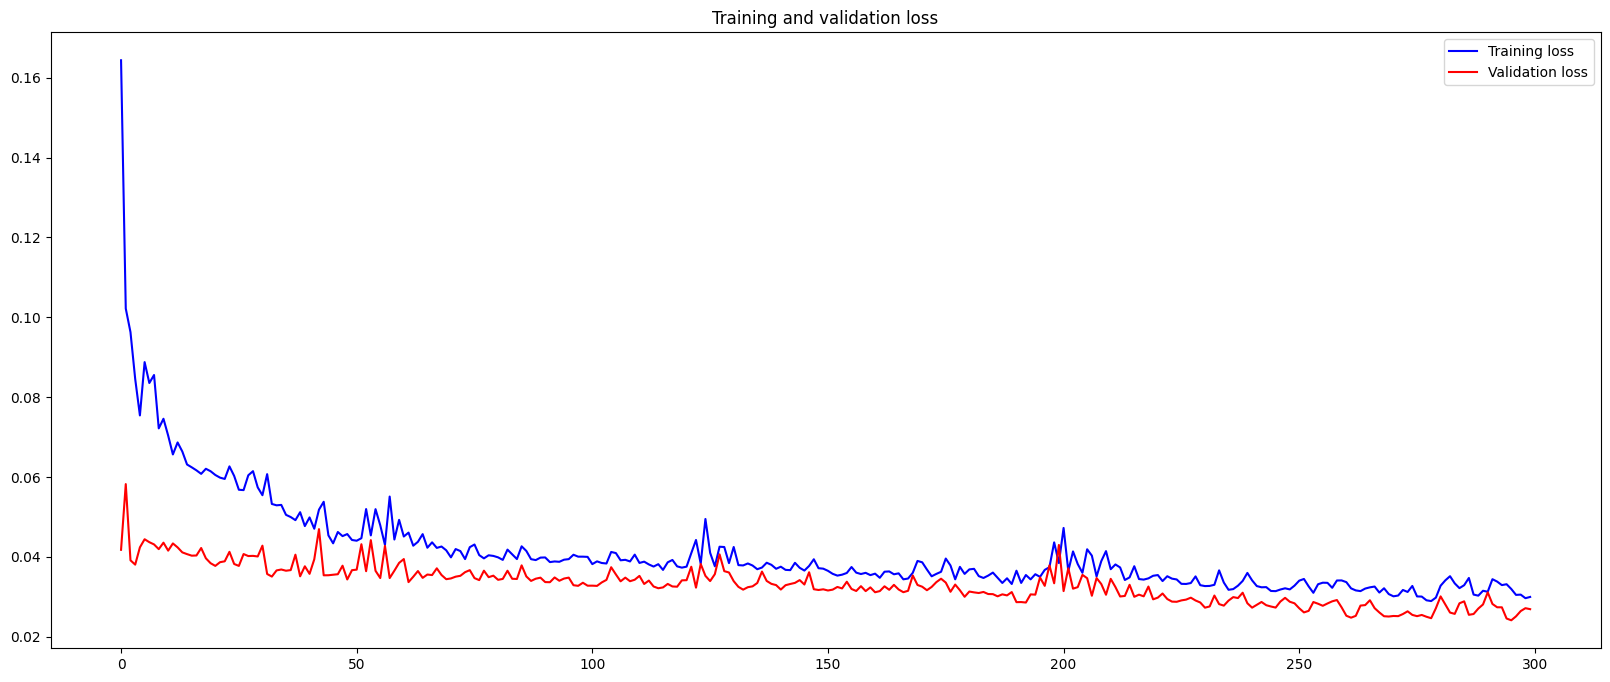

In [21]:
plot_loss(history_conv_lstm)

In [22]:
conv_lstm_model = tf.keras.models.load_model(
    "model_experiments/model_conv_lstm.keras")

model_preds = make_preds(conv_lstm_model, x_test_conv_lstm)
model_results = evaluate_preds(y_true=tf.squeeze(y_test),
                               y_pred=model_preds)

model_results

3/3 [==============================] - 1s 23ms/step


{'mae': 0.020795636, 'mse': 0.0007058003, 'r2': 0.6613661050796509}

#### Plot predictions

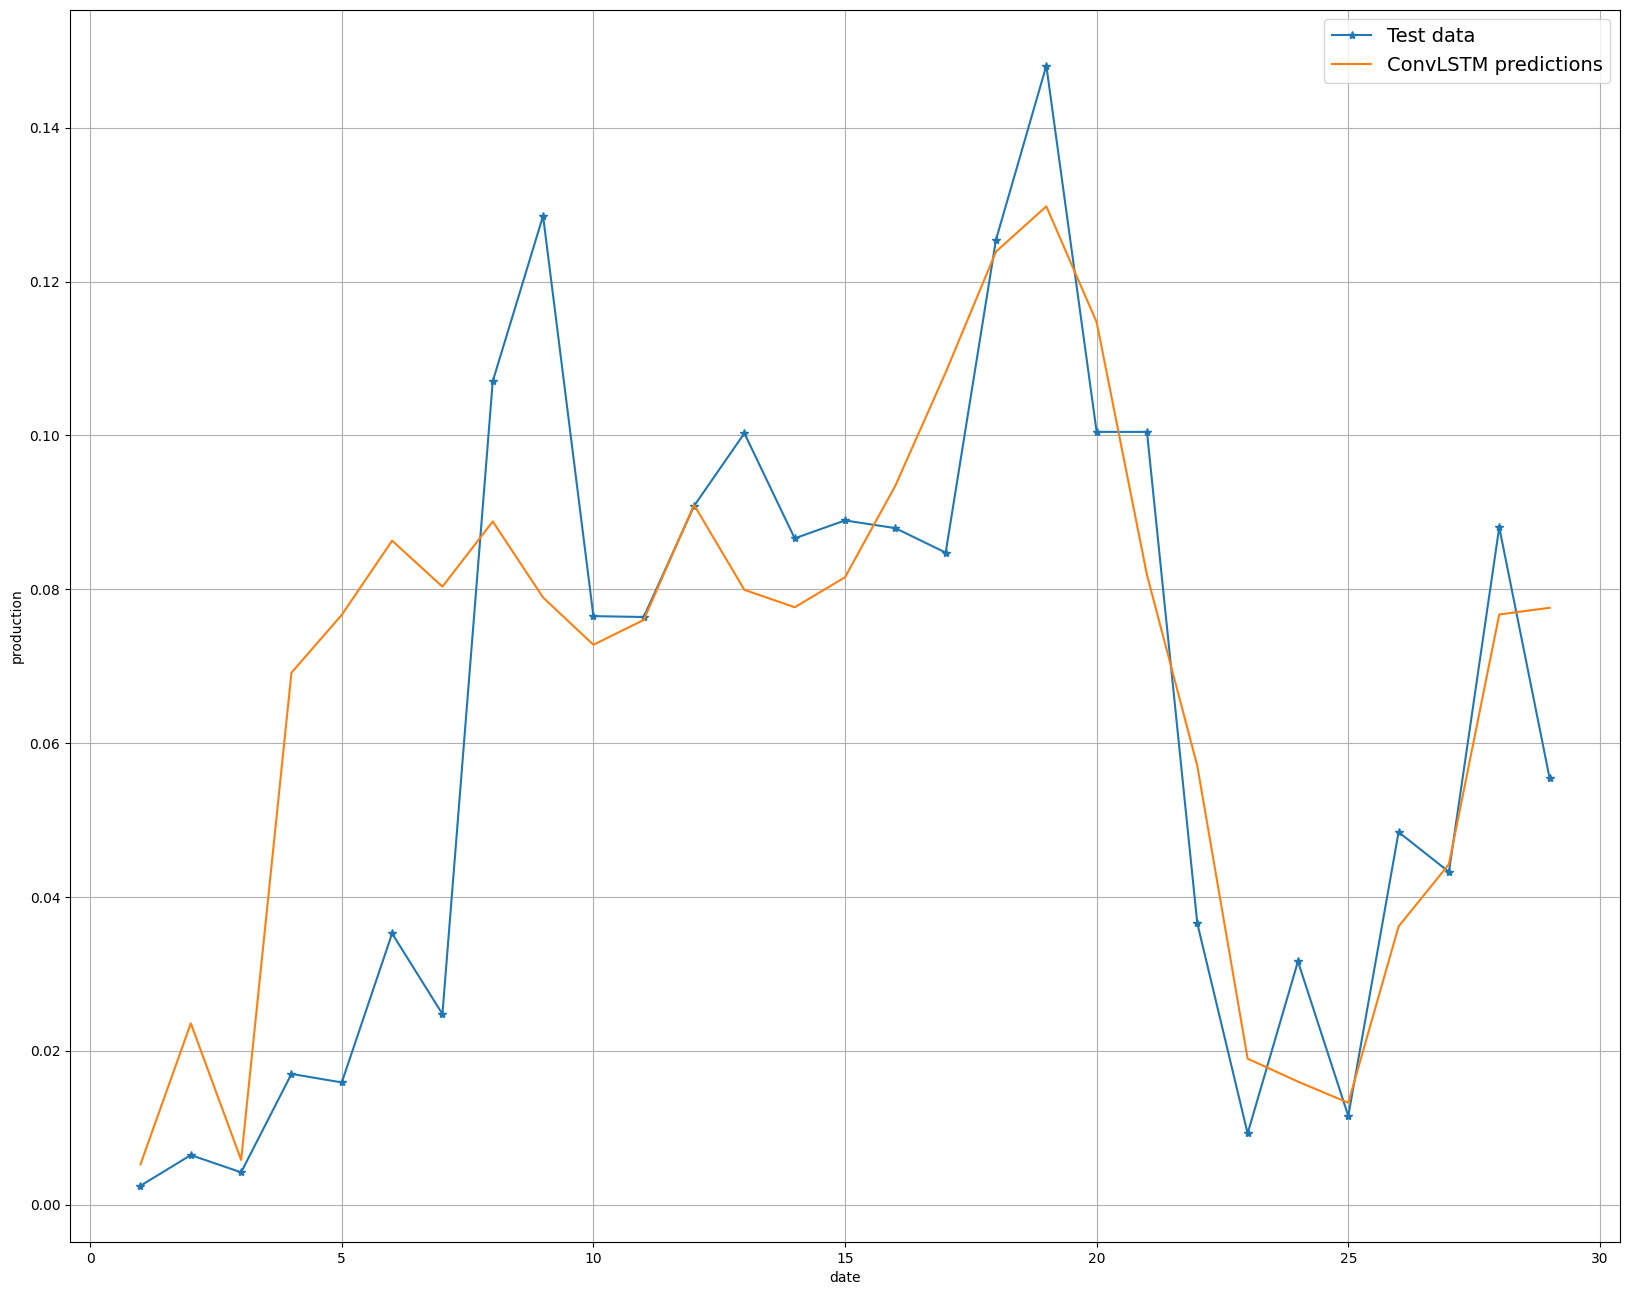

In [23]:
import numpy as np

start_offset = 1
end_offset = 30
plt.figure(figsize=(20, 16))


plot_time_series(
    timesteps=np.arange(x_test.shape[0]),
    values=y_test,
    start=start_offset,
    end=end_offset,
    format='-*',
    label="Test data"
)

plot_time_series(
    timesteps=np.arange(x_test.shape[0]),
    values=model_preds,
    start=start_offset,
    end=end_offset,
    format="-",
    label="ConvLSTM predictions"
)